(8, 32, 240, 320, 3)


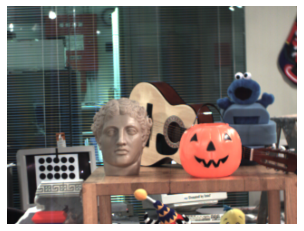

In [19]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# 定义光场的行列数
rows, cols = 8, 32
image_height, image_width = 240, 320  # 每张图像的分辨率

# 初始化用于存储光场数据的 NumPy 数组
light_field = np.zeros((rows, cols, image_height, image_width, 3), dtype=np.uint8)

# 读取图像数据
counter = 1  # 文件名计数器从001开始
for i in range(rows):
    for j in range(cols):
        # 生成文件名：lowtoys001.bmp 到 lowtoys256.bmp
        filename = fr'./toyLF/lowtoys{counter:03d}.bmp'
        img = cv2.imread(filename)
        if img is not None:
            img = cv2.resize(img, (image_width, image_height))  # 确保图像大小一致
            light_field[i, j] = img  # 将图像存储在正确的行列位置
        else:
            print(f"图像 {filename} 未找到")
        counter += 1  # 每读取一张图像，计数器加1


print(light_field.shape)

# 显示读取的第0行第0列图像
plt.imshow(cv2.cvtColor(light_field[0, 31], cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


In [18]:
import numpy as np
from scipy.interpolate import RegularGridInterpolator

def resample_light_field(light_field, new_u, new_v):
    """
    微透镜间光场重采样，通过在 U 和 V 维度上插值提高方向分辨率
    参数：
    - light_field: 原始光场数据，形状为 (U, V, X, Y, C)
    - new_u: 插值后的 U 维度的采样点数量
    - new_v: 插值后的 V 维度的采样点数量
    
    返回：
    - resampled_light_field: 重采样后的光场数据，形状为 (new_u, new_v, X, Y, C)
    """
    # 获取原始光场数据的维度
    U, V, X, Y, C = light_field.shape
    
    # 原始的坐标网格
    u_grid = np.linspace(0, U - 1, U)
    v_grid = np.linspace(0, V - 1, V)
    x_grid = np.arange(X)
    y_grid = np.arange(Y)
    
    # 创建插值函数
    interpolating_function = RegularGridInterpolator(
        (u_grid, v_grid, x_grid, y_grid), light_field, bounds_error=False, fill_value=None
    )
    
    # 新的方向采样网格
    new_u_grid = np.linspace(0, U - 1, new_u)
    new_v_grid = np.linspace(0, V - 1, new_v)
    new_x_grid, new_y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')
    
    # 初始化结果数组，使用 uint8 数据类型
    resampled_light_field = np.zeros((new_u, new_v, X, Y, C), dtype=np.uint8)
    
    # 进行插值计算，并填充到结果数组中
    for i, u in enumerate(new_u_grid):
        for j, v in enumerate(new_v_grid):
            # 生成该 (u, v) 平面上所有 (x, y) 的插值点
            points = np.array([[u, v, x, y] for x in range(X) for y in range(Y)])
            
            # 进行插值并重塑为 (X, Y, C) 形状
            interpolated_values = interpolating_function(points).reshape(X, Y, C)
            
            # 确保插值值在 [0, 255] 范围，并转换为 uint8
            resampled_light_field[i, j] = np.clip(interpolated_values, 0, 255).astype(np.uint8)
    
    return resampled_light_field

In [20]:
new_u, new_v = 16, 64
resampled_light_field = resample_light_field(light_field, new_u, new_v)

print("原始光场数据形状：", light_field.shape)
print("重采样后的光场数据形状：", resampled_light_field.shape)

原始光场数据形状： (8, 32, 240, 320, 3)
重采样后的光场数据形状： (16, 64, 240, 320, 3)


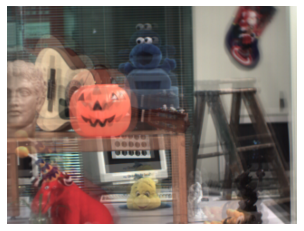

In [41]:
# 显示读取的第0行第0列图像
img_to_display = resampled_light_field[7, 33]
plt.imshow(cv2.cvtColor(img_to_display, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [63]:
import numpy as np
from scipy.interpolate import RegularGridInterpolator

def resample_light_field(LF, new_U, new_V, new_X, new_Y):
    """
    对光场数据进行四线性插值并确保返回的数据类型为 uint8。
    
    参数：
    - LF: 原始光场数据，形状为 (U, V, X, Y, C)
    - new_U: 插值后的 U 维度的采样点数量
    - new_V: 插值后的 V 维度的采样点数量
    - new_X: 插值后的 X 维度的采样点数量
    - new_Y: 插值后的 Y 维度的采样点数量
    
    返回：
    - resampled_LF: 重采样后的光场数据，形状为 (new_U, new_V, new_X, new_Y, C)，数据类型为 uint8
    """
    U, V, X, Y, C = LF.shape
    
    # 原始的光场坐标网格
    u_grid = np.arange(U)
    v_grid = np.arange(V)
    x_grid = np.arange(X)
    y_grid = np.arange(Y)
    
    # 创建插值函数
    interpolating_function = RegularGridInterpolator((u_grid, v_grid, x_grid, y_grid), LF, bounds_error=False, fill_value=None)
    
    # 新的方向和空间采样网格
    new_u_grid = np.linspace(0, U - 1, new_U)
    new_v_grid = np.linspace(0, V - 1, new_V)
    new_x_grid = np.linspace(0, X - 1, new_X)
    new_y_grid = np.linspace(0, Y - 1, new_Y)
    
    # 创建插值网格
    Uq, Vq, Xq, Yq = np.meshgrid(new_u_grid, new_v_grid, new_x_grid, new_y_grid, indexing='ij')
    
    # 构建插值点的坐标，并重塑为插值函数输入所需的形状
    points = np.array([Uq.flatten(), Vq.flatten(), Xq.flatten(), Yq.flatten()]).T
    
    # 插值计算
    resampled_LF = interpolating_function(points)
    
    # 重塑为新的光场数据形状
    resampled_LF = resampled_LF.reshape(new_U, new_V, new_X, new_Y, C)
    
    # 将结果限制在 [0, 255] 范围内，并转换为 uint8 类型
    resampled_LF = np.clip(resampled_LF, 0, 255).astype(np.uint8)
    
    return resampled_LF

In [64]:
# 设置新的 U 和 V 采样数，假设我们要将方向分辨率从 8x32 提升到 15x63
# 设置新的 U, V, X, Y 分辨率
new_U, new_V, new_X, new_Y = 15, 63, 240, 320
resampled_light_field = resample_light_field(light_field, new_U, new_V, new_X, new_Y)


print("原始光场数据形状：", light_field.shape)
print("重采样后的光场数据形状：", resampled_light_field.shape)

原始光场数据形状： (8, 32, 240, 320, 3)
重采样后的光场数据形状： (15, 63, 240, 320, 3)


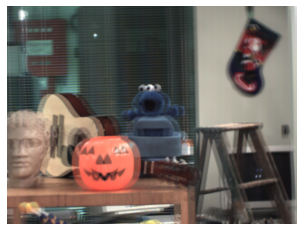

In [67]:
# 显示读取的第0行第0列图像
img_to_display = resampled_light_field[0, 1]
plt.imshow(cv2.cvtColor(img_to_display, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()